Import

In [76]:
import pandas as pd
import numpy as np
import optuna
import catboost as cb
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn import metrics
#from multiprocessing import Pool

from fitting import  get_objective_Catboost, fit_CatBoost,generate_predictions

In [77]:
def import_data(file):
    """create a dataframe from a csv file"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    return df

df_train = import_data("input/train.csv")

In [78]:
X_train, y_train = (df_train.drop(columns=['score']), np.log1p(df_train['score']))

Modelling

In [69]:
params = {'iterations': 530,
 'early_stopping_rounds': 38,
 'learning_rate': 0.053333529899705995,
 'depth': 6,
 'l2_leaf_reg': 80,
 'random_strength': 1.3806402421451422,
 'rsm': 0.505181534087604,
 'grow_policy': 'Depthwise',
 'sampling_frequency': 'PerTree',
 'min_data_in_leaf': 12,
 'border_count': 146,
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.37381073172705603}

In [70]:
if params is None:
    #This is timeconsuming code, and has already been run
    #The best parameters are already in the params variable
    objective = get_objective_Catboost(X_train, y_train)
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10)
    trial = study.best_trial

In [79]:
mod = fit_CatBoost(params,X_train, y_train)

In [80]:
test= import_data("input/train.csv")
testX = test.drop(columns=['score'])
testy =test['score']

In [81]:
predictions = generate_predictions(mod, testX)

In [82]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predictions, testy)
print(mse)

0.14368854377994866


Feature importance graphs

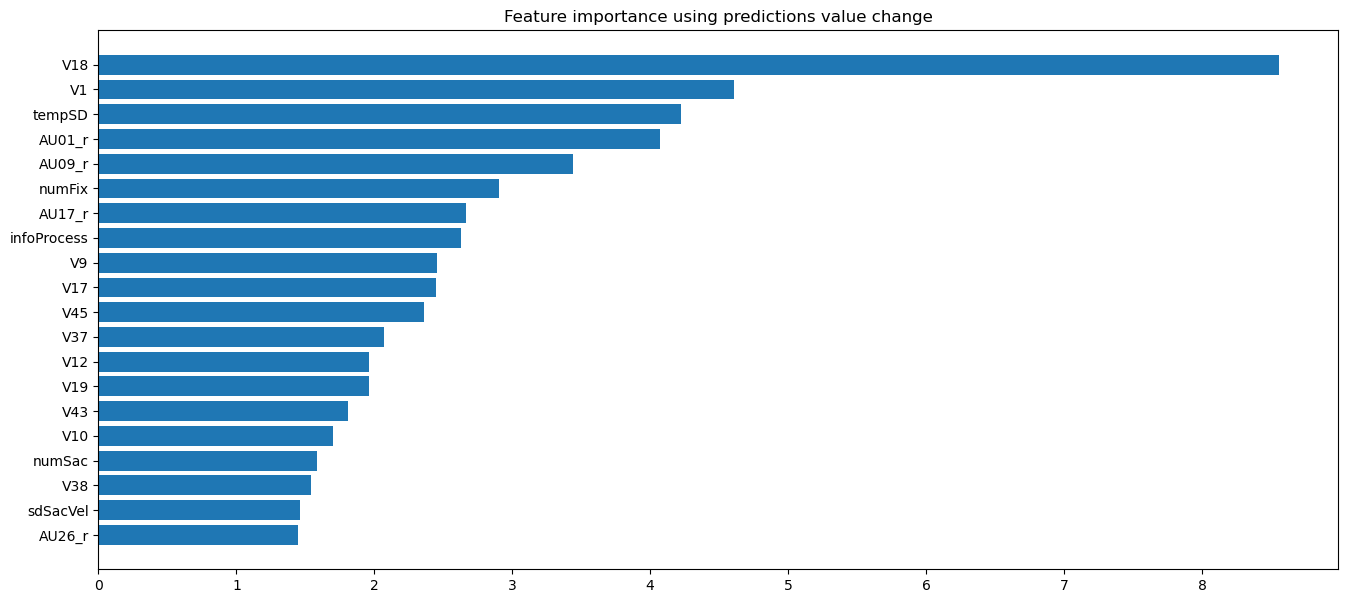

In [83]:
sorted_feature_importance = mod.feature_importances_.argsort()
top20features = sorted_feature_importance[-20:]
#plt.barh(X_train.columns[sorted_feature_importance], mod.feature_importances_[sorted_feature_importance])
plt.barh(X_train.columns[top20features], mod.feature_importances_[top20features])
plt.title("Feature importance using predictions value change")
plt.show()

Hjelpekode:

In [21]:
def log_loss(m, X, y): 
    return metrics.log_loss(y,m.predict_proba (X)[:,1])
    
def permutation_importances(model, X, y, metric):
    baseline = metric(model, X, y)
    imp = []
    for col in X.columns:
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        m = metric(model, X, y)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)

In [20]:
import shap

In [86]:
def get_feature_imp_plot(method):
    
    if method == "Permutation":
        fi =  permutation_importances(mod, testX, testy, log_loss)
    

    
    elif method == "ShapeValues":
        shap_values = mod.get_feature_importance(cb.Pool(testX, label=testy), type="ShapValues")
        shap_values = shap_values[:,:-1]
        shap.summary_plot(shap_values, testX) 
        
    else:
        fi = mod.get_feature_importance(cb.Pool(testX, label=testy), type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(testX.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
        ax.set_title("Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.show()

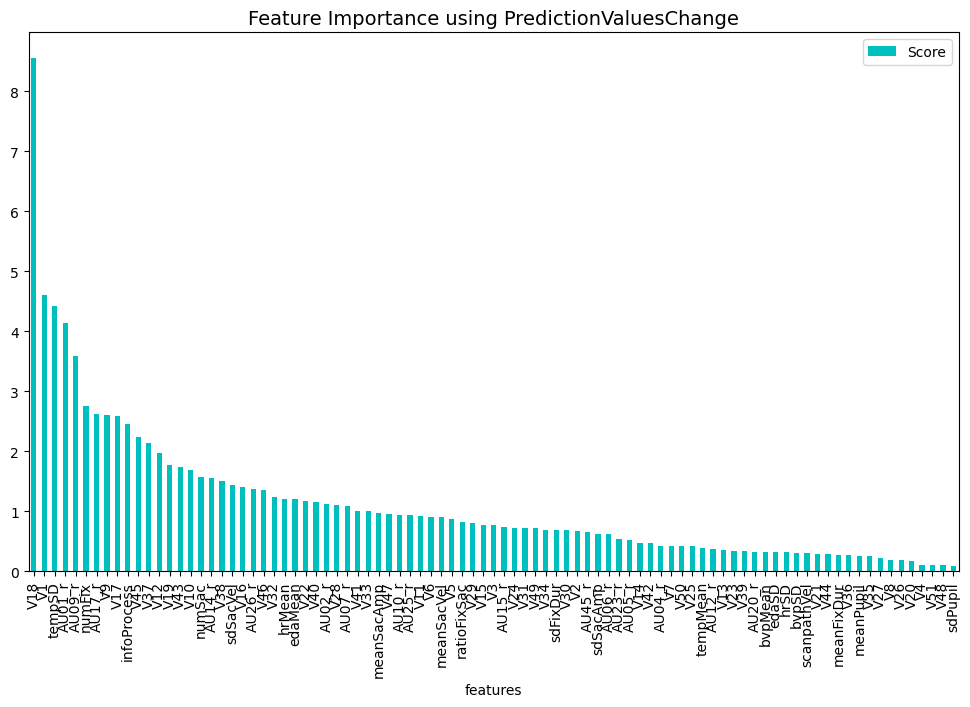

In [85]:
get_feature_imp_plot(method="PredictionValuesChange")

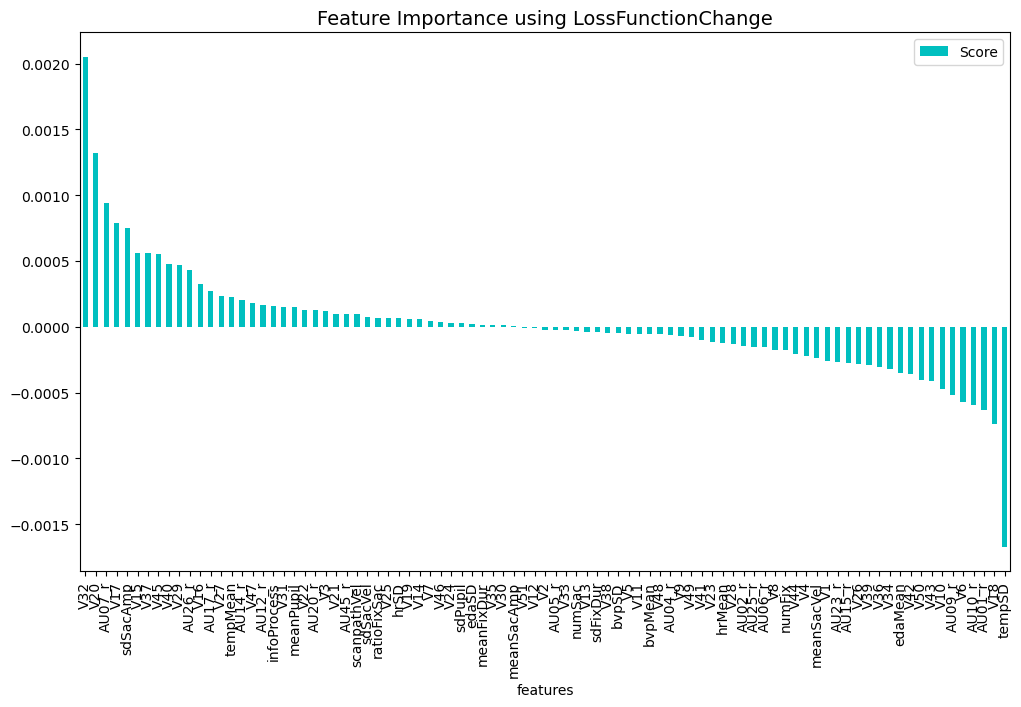

In [33]:
get_feature_imp_plot(method="LossFunctionChange")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


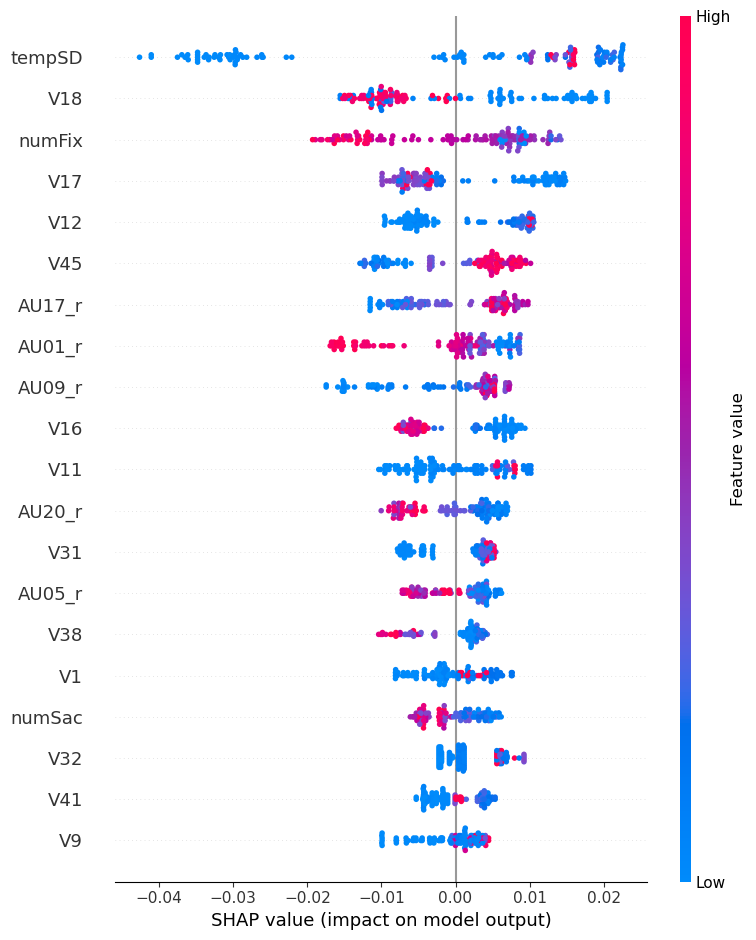

In [35]:
get_feature_imp_plot(method="ShapeValues")

Feature pair importance

In [59]:
fi = mod.get_feature_importance(cb.Pool(testX, label=testy), type="Interaction")

In [60]:
fi_new = []
for k, item in enumerate(fi):
    first = testX.dtypes.index[int(fi[k][0])]
    second = testX.dtypes.index[int(fi[k][1])]
    if first != second:
        fi_new.append([first + " | " + second, fi[k][2]])
    

In [61]:
fi_new[:5]

[['V15 | tempMean', 0.5589640304210328],
 ['AU02_r | AU12_r', 0.5156990131542522],
 ['V15 | AU02_r', 0.5112474689892568],
 ['V15 | AU12_r', 0.5112474689892568],
 ['V18 | tempSD', 0.49278518860062565]]

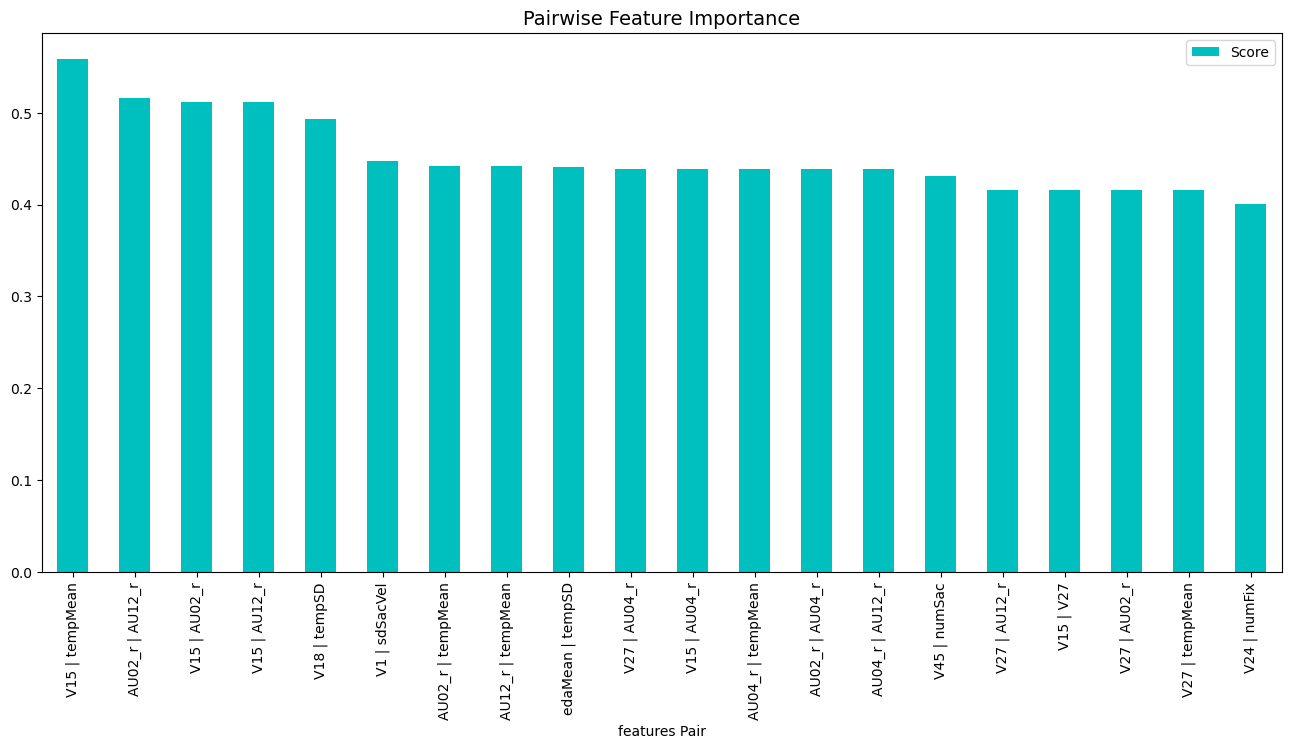

In [62]:
feature_score = pd.DataFrame(fi_new,columns=['Feature-Pair','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')[0:20]
plt.rcParams["figure.figsize"] = (16,7)
ax = feature_score.plot('Feature-Pair', 'Score', kind='bar', color='c')
ax.set_title("Pairwise Feature Importance", fontsize = 14)
ax.set_xlabel("features Pair")
plt.show()

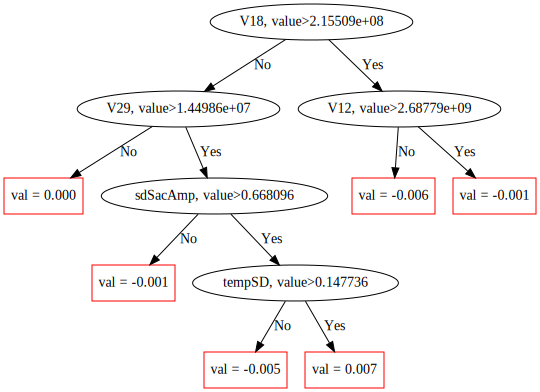

In [87]:
mod.plot_tree(tree_idx=0, pool=cb.Pool(testX, label=testy))